# Tutorial : Dynap-SE2 (UNDER CONSTRUCTION)

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Dict, Optional
import numpy as np
import json
import os
import time
import errno

# Samna
import samna
from samna.dynapse2 import *

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Dynap-SE2
from rockpool.devices.dynapse.config.board import DynapSimConfig, DynapSimCore
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.utils.figure import Figure
from rockpool.devices.dynapse.config.weights import WeightParameters

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



No protocol specified


## Utils

In [2]:
def set_parameter(parameters, name, coarse, fine):
    parameter = parameters[name]
    parameter.coarse_value = coarse
    parameter.fine_value = fine


def readable(file):
    try:
        f = open(file, mode="rb", buffering=0)
    except OSError:
        return False
    f.close()
    return True


def get_fpga_time(board):
    destination = Dynapse2Destination()
    destination.x_hop = -1
    destination.y_hop = -1
    destination.core = [True, True, True, True]

    event = NormalGridEvent()
    event.event = destination
    event.timestamp = 0

    while True:
        board.input_interface_write_events(0, [event])
        for timeout in range(1000):
            evs = board.read_events()
            if len(evs) > 0:
                return evs[-1].timestamp


## Connect to device

In [3]:
number_of_chips = 1
receiver_endpoint = "tcp://0.0.0.0:33335"
sender_endpoint = "tcp://0.0.0.0:33336"
node_id = 1
interpreter_id = 2
input_group_size = 16
delay=True
adaptation=False
stp=False
bitfile="./bitfiles/Dynapse2Stack.bit"

samna_node = samna.SamnaNode(sender_endpoint, receiver_endpoint, node_id)
devices = samna.device.get_unopened_devices()
board = samna.device.open_device(devices[0])


samna.setup_local_node(receiver_endpoint, sender_endpoint, interpreter_id)
samna.open_remote_node(node_id, "device_node")

remote =  samna.device_node

if not os.path.isfile(bitfile):
    print("Bitfile %s not found" % bitfile)
    exit(errno.ENOENT)

if not readable(bitfile):
    print("Cannot read %s" % bitfile)
    exit(errno.EACCES)

if not board.configure_opal_kelly(bitfile):
    print("Failed to configure Opal Kelly")
    exit(errno.EIO)

time.sleep(0.1)
board.reset_fpga()
time.sleep(0.1)

model = board.get_model()
model.reset(ResetType.PowerCycle, 0b1)
time.sleep(1)

In [4]:
myConfig = model.get_configuration()

## Configure Parameters Manually

In [5]:
print("Configuring parameters")

# set neuron parameters
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_GAIN_N", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_LEAK_N", 0, 50)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_REFR_N", 1, 40)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_DC_P", 0, 1)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_SPKTHR_P", 3, 254)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_PWTAU_N", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_GAIN_P", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_TAU_P", 0, 10)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_W_N", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_CASC_P", 5, 254)

# set synapse parameters  -- enabled AM and SC
set_parameter(myConfig.chips[0].cores[0].parameters, 'DEAM_ETAU_P', 2, 40)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DEAM_EGAIN_P', 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DENM_ETAU_P', 1, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DENM_EGAIN_P', 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DESC_ITAU_P', 1, 160)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DESC_IGAIN_P', 4, 40)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W0_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W1_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W2_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W3_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYPD_EXT_N', 3, 200)

Configuring parameters


## Configure Memory

In [6]:
sender_tag = 1024
receiver_tag = 15

In [7]:
print("Configuring cams")

# set CAM -- synapses
cams = [Dynapse2Synapse() for _ in range(64)]
cams[0].tag = sender_tag
cams[0].dendrite = Dendrite.ampa
cams[0].weight = [True, True, True, True]
myConfig.chips[0].cores[0].neurons[0].synapses = cams

Configuring cams


In [8]:
print("Configuring srams")

destinations = [Dynapse2Destination() for _ in range(4)]
destinations[0].tag = receiver_tag
destinations[0].core = [True, False, False, False]
destinations[0].x_hop = -2
myConfig.chips[0].cores[0].neurons[0].destinations = destinations

model.apply_configuration(myConfig)
time.sleep(1)


Configuring srams


In [9]:
get_fpga_time(board=board)

11029506

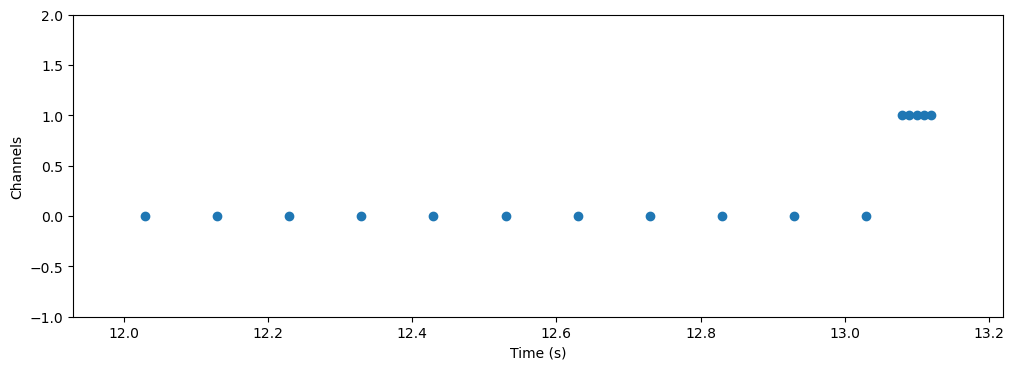

In [10]:
from rockpool.devices.dynapse.deploy.fpga import TSEventSE2
import numpy as np

ts = get_fpga_time(board=board) + 1000000
times = [t for t in np.arange(ts*1e-6, ts*1e-6 + 1.005, 1e-1)]
channels = [0 for _ in range(len(times))]
times2 = [t for t in np.arange(times[-1]+ 0.05, times[-1] + 0.1, 1e-2)]
channels += [1 for _ in range(len(times2))]
times = times + times2
ts = TSEventSE2(times, channels, t_start = ts*1e-6 - 0.1, t_stop = times[-1] + .1, idx_map={0:(1, 0, 0, 1024), 1:(15,-1,-1,2047)})
ts.plot()

In [11]:
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSEvent

from rockpool.devices.dynapse.config.board import DynapSimConfig, DynapSimCore
from rockpool.devices.dynapse.dynapsim import DynapSim

simconfig = DynapSimConfig.from_Dynapse2Configuration(myConfig)

In [12]:
n_in = len(simconfig.router.tag_map_in)
n_rec = len(simconfig.router.idx_map)
n_out  = len(simconfig.router.tag_map_out)
n_syn = 4

In [13]:
# --- DynapSim Layer --- #
dynapsim = DynapSim.from_DynapSimConfig(
    shape=(n_rec * n_syn, n_rec), has_rec=True, simconfig=simconfig
)
dynapsim

DynapSim  with shape (4, 1)

In [14]:
# --- Output Layer --- #
linear_out = LinearJax(
    shape=(n_rec, n_out),
    weight=simconfig.w_out,
    has_bias=False,
)
linear_out

LinearJax  with shape (1, 1)

In [15]:
model = Sequential(dynapsim, linear_out)
model


JaxSequential  with shape (4, 1) {
    DynapSim '0_DynapSim' with shape (4, 1)
    LinearJax '1_LinearJax' with shape (1, 1)
}

In [21]:
model.reset_state()
spikes_in = np.zeros((100, 4))
spikes_in[10] = 1
spikes_in[20] = 1
spikes_in[30] = 1
spikes_in[40] = 1
spikes_in[50] = 1
spikes_in[60] = 1
spikes_in[70] = 1
spikes_in[80] = 1
spikes_in[90] = 1
out, state, record_dict = model(spikes_in, record=True)

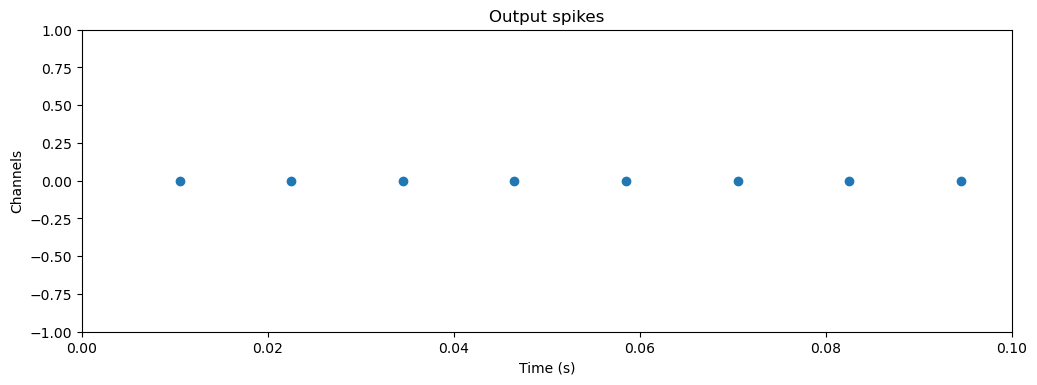

In [22]:
spike_ts_out = TSEvent.from_raster(out, name="Output spikes", periodic=True, dt=1e-3)
spike_ts_out.plot()

In [24]:
simconfig.time

DynapSimTime(t_pulse_ahp=array([3.273717e-05]), t_pulse=array([1.35275773e-05]), t_ref=array([0.0107829]), tau_ahp=array([2.48180593]), tau_ampa=array([0.00622751]), tau_gaba=array([1.97456191e-06]), tau_nmda=array([0.02612203]), tau_shunt=array([0.01306161]), tau_mem=array([0.01200967]))

In [25]:
simconfig.gain

DynapSimGain(r_gain_ahp=array([13047.51089153]), r_gain_ampa=array([53.45250766]), r_gain_gaba=array([5.64609701e-07]), r_gain_nmda=array([219.72870351]), r_gain_shunt=array([462.434723]), r_gain_mem=array([1377.48693116]))

In [26]:
simconfig.w_in

DeviceArray([[[6.073194e-07, 0.000000e+00, 0.000000e+00, 0.000000e+00]]],            dtype=float32)

In [27]:
simconfig.cores[0,0].export_Dynapse2Parameters()

{'SOIF_DC_P': (0, 1),
 'DENM_NMREV_N': (0, 0),
 'SOAD_GAIN_P': (3, 80),
 'DEAM_EGAIN_P': (3, 80),
 'DEGA_IGAIN_P': (0, 0),
 'DENM_EGAIN_P': (3, 80),
 'DESC_IGAIN_P': (4, 40),
 'SOIF_GAIN_N': (3, 80),
 'SOAD_PWTAU_N': (3, 80),
 'SYPD_EXT_N': (3, 200),
 'SOIF_REFR_N': (1, 40),
 'SOIF_SPKTHR_P': (3, 254),
 'SOAD_TAU_P': (0, 10),
 'DEAM_ETAU_P': (2, 40),
 'DEGA_ITAU_P': (5, 255),
 'DENM_ETAU_P': (1, 80),
 'DESC_ITAU_P': (1, 160),
 'SOIF_LEAK_N': (0, 50),
 'SYAM_W0_P': (5, 80),
 'SYAM_W1_P': (5, 80),
 'SYAM_W2_P': (5, 80),
 'SYAM_W3_P': (5, 80),
 'SOAD_W_N': (3, 80)}